# Template matching 2xxx SPED dataset with three phases

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import pyxem as pxm

import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
from diffsims.libraries.diffraction_library import load_DiffractionLibrary # Need this if we want to import diffraction library previously made

from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls
from pyxem.utils.plotting_utils import plot_template_over_pattern

import matplotlib.colors as mcolors
from orix.projections import StereographicProjection
from orix import plot, sampling
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d, Miller
from orix.io import load, save
from orix.projections import StereographicProjection
from orix.vector.vector3d import Vector3d

# Load data and plot

Navigation axis name,size,index,offset,scale,units
x,100,0,0.0,1.0,nm
y,100,0,0.0,1.0,nm
Signal axis name,size,,offset,scale,units
kx,128,,-1.2138,0.01904,$A^{-1}$
ky,128,,-1.2138,0.01904,$A^{-1}$


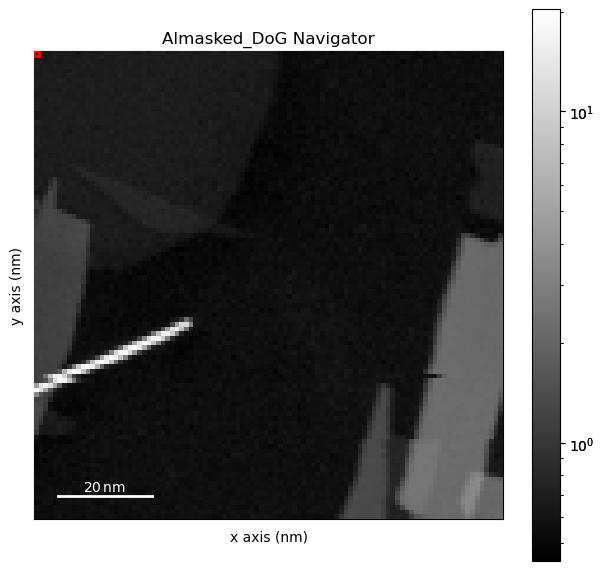

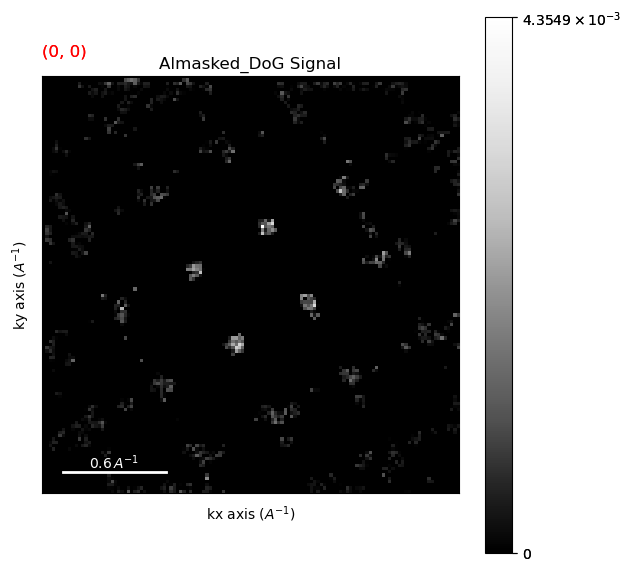

In [2]:
file = 'Almasked_DoG.hdf5'

experimental_data = hs.load(file)
experimental_data.set_signal_type('electron_diffraction')
experimental_data.plot(navigator_kwds=dict(norm='log'),cmap='Greys_r', norm='symlog')
experimental_data.axes_manager

## Some important parameters for the template matching collected here:

In [3]:
minimum_intensity = 1E-20   # min intensity included in simulations
shift   = 0.001             # shift used in transform func for template matching

# Maximum_excitation_error for each phase and orientation:
s_Th100 = 0.03
s_Th001 = 0.05
s_T1    = 0.022
s_list = [s_Th100, s_Th001, s_T1]

# The following process:
> 1) Get rotations to simulate DPs at and create structure library of phases (We can limit this to small tilt range around specific zones). For this case we will only include T1 and $\theta$' and filter out badly matched regions as Al in the end. Done because Al has overlapping refelctions with the precipitates.
> 2) Prepare a virtual microscope for simulations and create the diffraction library.
> 3) Perform the template matching on the scanned area.

# 1) Get rotations to simulate DPs at and create structure library of phases

### Importing structures and giving appropriate phase names

In [4]:
# Importing structures
structure_Theta= diffpy.structure.loadStructure('thetaprime.cif')
structure_T1   = diffpy.structure.loadStructure('T1.cif')

# List of phase names:
phases         = ['ThetaPrime100', 'ThetaPrime001', 'T1']

# List of structures:
structures = [structure_Theta, structure_Theta, structure_T1]

### Getting rotation lists for the different symmetries

In [5]:
resolution = 0.5 # maximum angle in degrees between nearest templates.

hex_grid   = get_beam_directions_grid("hexagonal", resolution, mesh="spherified_cube_edge") #T1, full rotation list
tetra_grid = get_beam_directions_grid("tetragonal", resolution, mesh="spherified_cube_edge") #theta, full rotation list

print('Number of patterns \ntetra:', tetra_grid.shape[0], '\nhex:', hex_grid.shape[0])

Number of patterns 
tetra: 12376 
hex: 16209


c:\Users\torit\Anaconda3\envs\templatematch_0123\lib\site-packages\diffsims\generators\sphere_mesh_generators.py:514: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


### A tilt limiting finction

In [6]:
def _new_structure_matrix_from_alignment(old_matrix, x=None, y=None, z=None):
    """Taken from orix v0.9, see
    https://github.com/pyxem/orix/blob/fb269b0456163aa3ac1f80498a9894c53953dccb/orix/crystal_map/phase_list.py#L794-L845.
    
    Explanation of why changing the structure matrix (base) to use orix with
    ReciPro, which uses another alignment, is needed:
    https://orix.readthedocs.io/en/stable/crystal_reference_frame.html.
    """
    if sum([i is None for i in [x, y, z]]) > 1:
        raise ValueError("At least two of x, y, z must be set.")

    # Old direct lattice base (row) vectors in Cartesian coordinates
    old_matrix = Vector3d(old_matrix)
    ad, bd, cd = old_matrix.unit

    # Old reciprocal lattice base vectors in cartesian coordinates
    ar = bd.cross(cd).unit
    br = cd.cross(ad).unit
    cr = ad.cross(bd).unit

    # New unit crystal base
    new_vectors = Vector3d.zero((3,))
    axes_mapping = {"a": ad, "b": bd, "c": cd, "a*": ar, "b*": br, "c*": cr}
    for i, al in enumerate([x, y, z]):
        if al in axes_mapping.keys():
            new_vectors[i] = axes_mapping[al]
    other_idx = {0: (1, 2), 1: (2, 0), 2: (0, 1)}
    for i in range(3):
        if np.isclose(new_vectors[i].norm, 0):
            other0, other1 = other_idx[i]
            new_vectors[i] = new_vectors[other0].cross(new_vectors[other1])

    # New crystal base
    new_matrix = new_vectors.dot(old_matrix.reshape(3, 1)).round(12)

    return new_matrix

#Defining a function that returns the tilt range of interest around a given zone axis for a given structure:
def get_tilt_range_around_zone(phase_object, zone_axis, euler_grid, max_tilt):
    '''
    phase_object : Orix phase object (Ex. Phase(name='T1', space_group=191, structure=T1_structure))
    zone_axis : The zone axis you want to rotate about
    euler_grid : the total rotation grid needed to describe whole crystal
    max_tilt : The maximum angle deviation from zone axis to be included
    '''
    # Input
    uvw = zone_axis
    phase = phase_object.deepcopy()
    
    # Change structure matrix (crystal lattice base)
    # NB! Use with care, since orix assumes another alignment, e1||a, e3||c*!
    lat = phase.structure.lattice
    new_base = _new_structure_matrix_from_alignment(lat.base, x="a*", z="c")
    lat.setLatBase(new_base)
        
    # Sample grid
    g_grid = Rotation.from_euler(np.deg2rad(euler_grid))

    # Rotate Zs (optic axis) into *cartesian* crystal coordinates
    rz = Vector3d.zvector()
    hz = g_grid * rz

    # Cartesian crystal coordinates in Miller indices <uvw> (unit cell coordinates)
    hz_miller = Miller(xyz=hz.data, phase=phase)
    hz_miller.coordinate_format = "uvw"

    # Rotate into fundamental sector defined in orix
    hz_miller = hz_miller.in_fundamental_sector()

    # Define zone axis and symmetrically equivalent directions
    za = Miller(uvw=uvw, phase=phase)
    za2 = za.symmetrise(unique=True)

    # Get disorientation angle (smallest misorientation angle under symmetry)
    hz_miller2 = hz_miller.reshape(hz_miller.size, 1)
    za2 = za2.reshape(1, za2.size)
    all_angles = za2.angle_with(hz_miller2)
    angles = all_angles.min(axis=1)

    # Get orientations within threshold
    mask = angles <= np.deg2rad(threshold)
    masked_euler_grid = euler_grid[mask]
    
    # This plots the orientations included in the template library
    if False:
        fig = plt.figure()
        ax = fig.add_subplot(projection="ipf", symmetry=phase.point_group)
        ax.scatter(hz_miller, c=angles)
        ax.scatter(hz_miller[mask], c="w", ec="k")
        fig.tight_layout()
        # fig = hz_miller.scatter(
        # hemisphere="both",
        # c=angles,
        # axes_labels=["Xc", "Yc"],
        # return_figure=True,
        # figure_kwargs=dict(figsize=(15, 15)),
        # )
        # fig.tight_layout()
    
    return masked_euler_grid

### Now limit the rotations within a threshold

In [7]:
# Threshold value for tilts away from the possible precipitate orientations in degrees:
threshold = 3

### Theta Prime

In [8]:
# Create a phase object (orix) for a crystal structure and give the expected zone axis:
uvw_001 = [0, 0, 1]
uvw_100 = [1, 0, 0]
ThetaPrime_phase = Phase(name='ThetaPrime', space_group=119, structure=structure_Theta)

# Limit tilt range to orientations around zone axis to the threshold value:
ThetaPrime_grid_masked_001 = get_tilt_range_around_zone(ThetaPrime_phase, uvw_001, tetra_grid, threshold)
ThetaPrime_grid_masked_100 = get_tilt_range_around_zone(ThetaPrime_phase, uvw_100, tetra_grid, threshold)
print(ThetaPrime_grid_masked_001.size//3) # Printing number of templates generated
print(ThetaPrime_grid_masked_100.size//3) # Printing number of templates generated

20
35


### T1

In [9]:
# Create a phase object (orix) for a crystal structure and give the expected zone axis:
uvw_041 = [0,-4,1]
T1_phase = Phase(name='T1', space_group=191, structure=structure_T1)

# Limit tilt range to orientations around zone axis to the threshold value:
T1_grid_masked_041 = get_tilt_range_around_zone(T1_phase, uvw_041, hex_grid, threshold)
T1_grid_masked_041.size//3 # Printing number of templates generated

147

## Create a structure library

In [10]:
# List of rotations:
rot_grids = [ThetaPrime_grid_masked_100, ThetaPrime_grid_masked_001, T1_grid_masked_041]

# Collect all in a structure library used to simulate our diffraction patterns:
library_Th100 = StructureLibrary([phases[0]], [structures[0]], [rot_grids[0]])
library_Th001 = StructureLibrary([phases[1]], [structures[1]], [rot_grids[1]])
library_T1    = StructureLibrary([phases[2]], [structures[2]], [rot_grids[2]])
library_phases = [library_Th100, library_Th001, library_T1]

# 2) Prepare microscope for simulations and create diffraction library

### "Turn on the microscope"

In [11]:
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                shape_factor_model="linear",
                                scattering_params=None,
                                minimum_intensity=minimum_intensity,
                                )

lib_gen = DiffractionLibraryGenerator(diff_gen)

### And then simulate library for given s with resolution as set earlier

In [12]:
# half size of the images
half_shape = (experimental_data.data.shape[-2]//2, experimental_data.data.shape[-1]//2)
print("Half shape:2" ,half_shape)
diffraction_calibration = experimental_data.axes_manager[2].scale
# maximum radius in reciprocal space to calculate spot intensities for
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration
print("Reciprocal radius:", reciprocal_radius)
# Calculate the simulated DP library
from diffsims.libraries.diffraction_library import DiffractionLibrary

# Some dictionary stitching to get individual excitatin errors each phase:
diff_lib_full = DiffractionLibrary()
for i, s in enumerate(s_list): # One s for each phase
    # Calculate the simulated DP library
    diff_lib_full[phases[i]] = lib_gen.get_diffraction_library(library_phases[i],   # Collecting structure library for phase_i
                                            calibration=diffraction_calibration,
                                            reciprocal_radius=reciprocal_radius,
                                            half_shape=half_shape,
                                            with_direct_beam=False,
                                            max_excitation_error=s)[phases[i]]      # if [phases[i]] is not included here the keys of diff_lib_full would be ["some_phase"]->["some_phase"]->['simulations', ... ]
diff_lib = diff_lib_full
diff_lib.keys() # This shows you which phases you have, can then also access diff_lib['key'].keys() and so on...

#Optionally save it for later:
#diff_lib.pickle_library("precips_lib_0123.pickle")

Half shape:2 (64, 64)
Reciprocal radius: 1.723304078565359


dict_keys(['ThetaPrime100', 'ThetaPrime001', 'T1'])

In [13]:
# Can load previously made library:
#diff_lib = load_DiffractionLibrary("precips_lib_0123.pickle", True)

### Can check random simulations (with too high s the DPs have too many reflections)

['ThetaPrime100', 'ThetaPrime001', 'T1']
[ 0. 87. 90.]
[ 0.  0. 90.]
[ 0.         51.49460536 60.1171875 ]


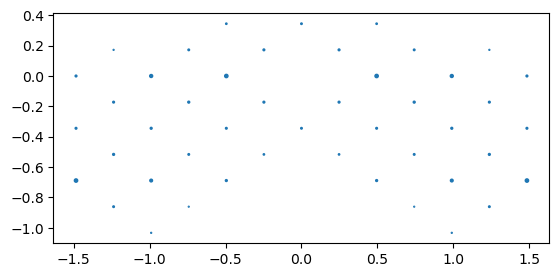

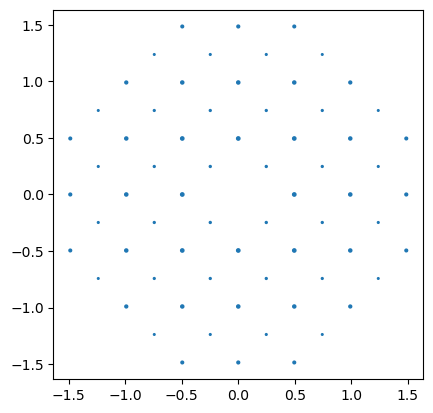

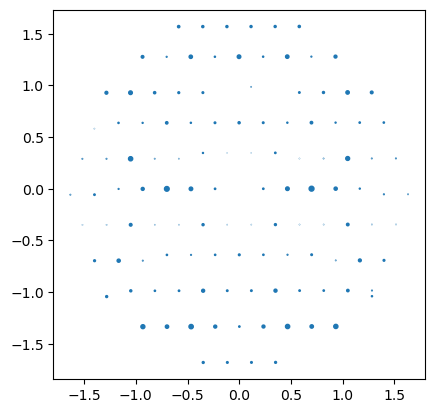

In [14]:
print(phases)
if(True):
    diff_lib[phases[0]]['simulations'][0].plot()
    print(diff_lib[phases[0]]['orientations'][0])
    diff_lib[phases[1]]['simulations'][0].plot()
    print(diff_lib[phases[1]]['orientations'][0])
    diff_lib[phases[2]]['simulations'][0].plot()
    print(diff_lib[phases[2]]['orientations'][0])

# 3) Do template matching

log shift function used in template matching, small shift amplifies weak reflections

In [15]:
print(shift)
def log_shift(raw):
    ''''
    Parameters
    -------
    raw : np.array((128, 128)). The raw data.
    shift : float. Introduces a shift for the log. To account for pixels with 0 value.
    
    Returns
    -------
    log_shift : np.array((128,128)). The log of the raw data.
    '''
    log_shift = np.log10(raw+shift) - np.log10(shift) - 0.05
    return log_shift

0.001


In [16]:
# Parameters for matching:
delta_r = 1                         # res in inkreasing k value 
delta_theta = 1                     # res in rotation basically, azimuthal angle
max_r = experimental_data.axes_manager[2].size//2  # Max k to check IN PIXELS, Default (None) is from center of DP to corner.
intensity_transform_function = log_shift           # Function to apply to both image and template intensities on an element by element basis prior to comparison. Note that the function is performed on the CPU.
find_direct_beam     = False
direct_beam_position = None
normalize_image      = True         # Normalize the images in the correlation coefficient calculation
normalize_templates  = True         # Normalize the templates in the correlation coefficient calculation
frac_keep = 1 
n_keep    = None
n_best    = 5                       # keeping n_best matches

result, phasedict = iutls.index_dataset_with_template_rotation(experimental_data,
                                                                diff_lib,
                                                                n_best                       = n_best,
                                                                frac_keep                    = frac_keep,
                                                                n_keep                       = n_keep,
                                                                delta_r                      = delta_r,
                                                                delta_theta                  = delta_theta,
                                                                max_r                        = max_r,
                                                                intensity_transform_function = intensity_transform_function,
                                                                normalize_images             = normalize_image,
                                                                normalize_templates          = normalize_templates,
                                                                )

[########################################] | 100% Completed | 180.81 s


## We can now get a phase map

### Creating custom colormap for phases:

In [17]:

from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

color_names = ['linen', 'darkorange', 'dodgerblue', 'forestgreen']
colors = [to_rgba(c) for c in color_names]

cmap = LinearSegmentedColormap.from_list('gt_cmap', colors, N=len(color_names))

### We need the correlation map to find a suitable threshold for filtering out what is aluminium:

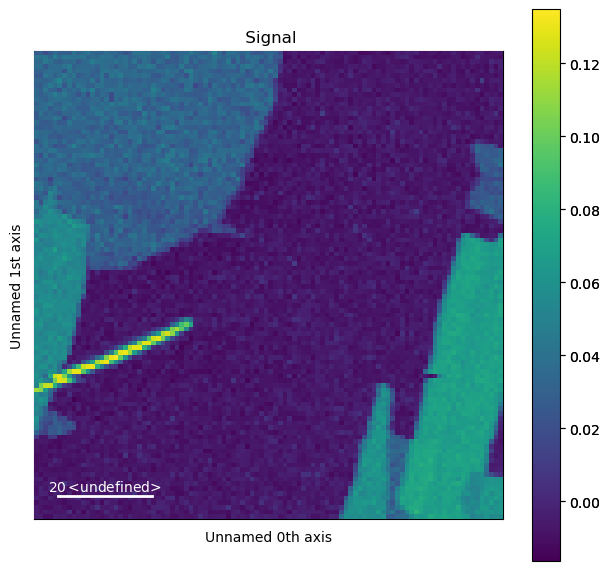

In [18]:
corr_map = hs.signals.BaseSignal(result['correlation'][:,:,0]) # 0 is best match, 1 next best and so on
corr_map.plot(cmap='viridis')

#### Insert a region of interest and move to Al region (low scores due to bad match for precipitate DPs):

In [19]:
roi = hs.roi.RectangularROI(left=49, top=33, right=81, bottom=65)
roi.add_widget(corr_map) # Put this in correct position before running next cell

#### Then crop out this region and use the maximum value as initial guess for Al threshold

0.011015317978663642


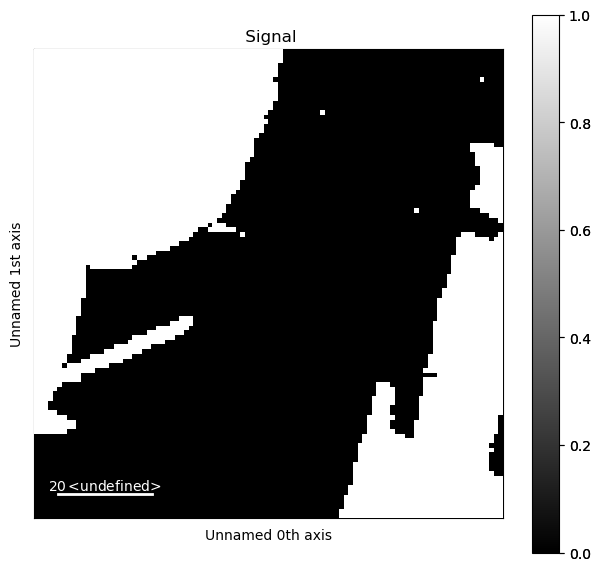

In [20]:
new_region = corr_map.isig[roi[0]:roi[1],roi[2]:roi[3]]
print(new_region.data.max())

Al_mask = corr_map > new_region.data.max()
Al_mask.plot()

### From our results we can get the indexes found and apply the Al mask to the map:

{0: 'ThetaPrime100', 1: 'ThetaPrime001', 2: 'T1'}

Used: 
 s = [0.03, 0.05, 0.022] for [ThP100, ThP001, T1] 
 shift = 0.001 
 min intensity = 1e-20


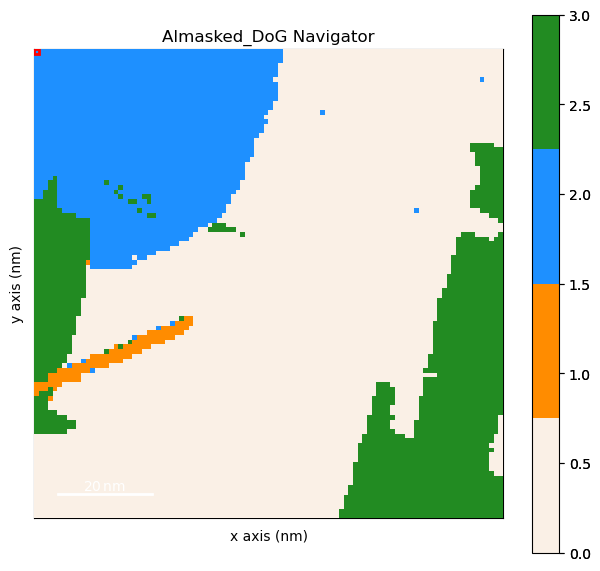

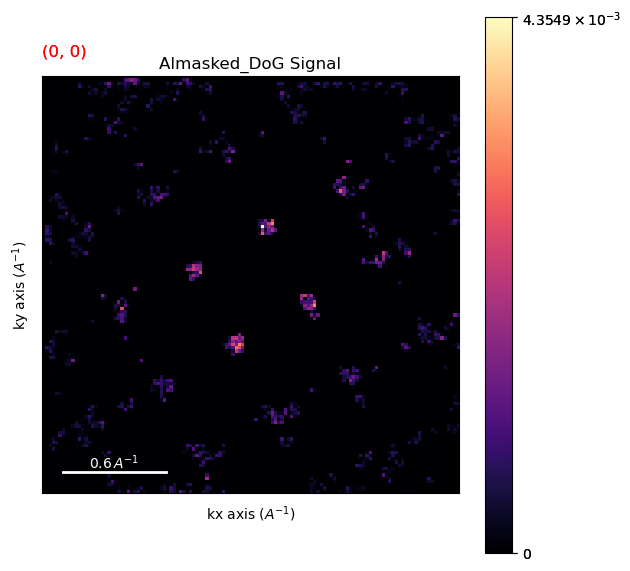

In [21]:
phase_map = hs.signals.BaseSignal(result['phase_index'][:,:,0] + 1) # +1 here because we want Al to be 0, ThP_100 = 1, ThP_001 = 2 and T1 = 3. As Al not in template bank we have to shift it
phase_map = phase_map*Al_mask

# Plot phase map with our cmap above:
experimental_data.plot(navigator=phase_map, 
                       norm='symlog', 
                       cmap='magma', 
                       navigator_kwds=dict(colorbar=True, cmap=cmap)
                      )
# Print the phase correspinding to numbers in phase map:
print(phasedict)
print('\nUsed: \n s =', s_list, "for [ThP100, ThP001, T1]",'\n shift =', shift, '\n min intensity =', minimum_intensity)

# We can also plot the matched sim DP on exp DP for individual points of the scan:

(There is some issue with the code for the in plane rotation however when using more than one phase in the template bank)

Orientation of ( 24 , 61 ) is [990.          88.00030436  89.        ]
in_plane_angle = 990.0
ThetaPrime100
[ 0.         88.00030436 89.        ]
ThetaPrime100


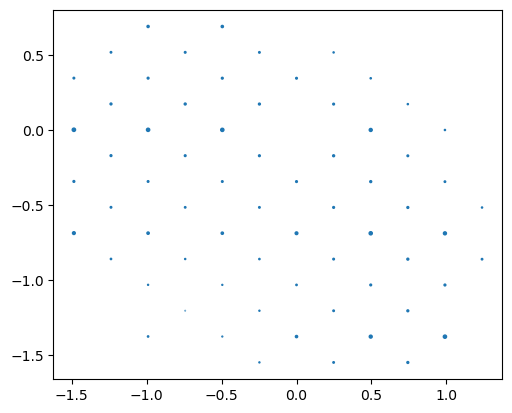

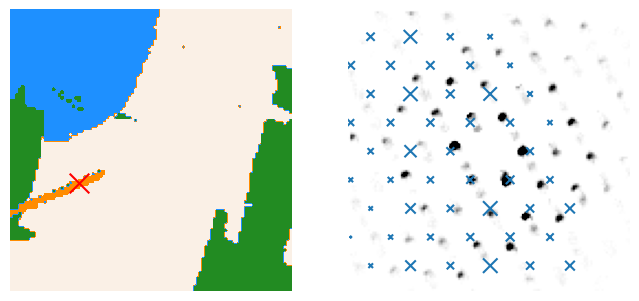

In [22]:
px = 24
py = 61
n_sol = 0 # 0 = best, 1 = next best, ...

solution = result["orientation"]
# Query the necessary info from the solution
sim_sol_index = result["template_index"][py, px, n_sol]   # Collects (py,px) in solution map n
mirrored_sol = result["mirrored_template"][py, px, n_sol] # mirrored template represents whether the original template best fits (False) or the mirror image (True)
in_plane_angle = solution[py, px, n_sol, 0] # Orientations, the first angle is the in plane angle (When using multiple phases this is not correctly calculated.)
print('Orientation of (', px,',', py, ')','is', solution[py, px, n_sol])
print('in_plane_angle =', in_plane_angle)


# Get the phase and simulation matched:
found_phase = phases[result['phase_index'][py, px, n_sol]]
print(found_phase)

used_sim = diff_lib[found_phase]["simulations"][sim_sol_index]  # Collects the simulation fitted from template match
used_sim.plot()
print(diff_lib[found_phase]["orientations"][sim_sol_index])
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
# plotting phase map and the point we chose
ax[0].imshow(phase_map, cmap=cmap)
ax[0].scatter([px], [py], c="r", marker='x', s=200)
# plotting the diffraction pattern and template
plot_template_over_pattern(experimental_data.inav[px,py].data,   # DP at px, py
                                 used_sim,                       # simulated pattern found to fit best for DP at px, py
                                 ax=ax[1],                       # Optional, to get DP in same fig as correlation map
                                 in_plane_angle = in_plane_angle,# There is a bug in the collected in plane angle from template matchng when using multiple phases. It then seems to add up the in plane rotation found for each best fit phase.
                                 coordinate_system = "cartesian", 
                                 size_factor = 20,               # This changes size of plotted X for DP spot marking
                                 vmax=0.02,
                                 mirrored_template=mirrored_sol,
                                 find_direct_beam=False,
                                 cmap = "Greys",
                                 marker_color = '#1f77b4ff',
                                 #direct_beam_position = (63,63)
                                )
for i in ax:
    i.axis("off")
print(found_phase)